# 📈 Sales Forecasting Project
This notebook demonstrates how to forecast future sales (Jan–Mar 2026) using historical sales data from 2025. We will:
- Load and explore the data
- Split into training (75%) and testing (25%) sets
- Apply forecasting methods (Moving Average and Linear Regression)
- Compare models using MAPE
- Forecast Jan–Mar 2026 using the best model

In [1]:
# 📊 Forecasting Sales for a Single Product

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [22]:
# Load the dataset
df = pd.read_excel("Forecasting_Project_SalesData_Reshaped.xlsx")
df["Month"] = pd.to_datetime(df["Month"], format="%b-%Y")
df.sort_values(["Product", "Month"], inplace=True)


In [23]:
# 🔍 Choose your product
product_name = 'Product_6'  # Change to test other products

# Filter product data
product_df = df[df["Product"] == product_name].reset_index(drop=True)


In [24]:
# Train-test split
n_total = len(product_df)
n_train = int(n_total * 0.75)
train_df = product_df.iloc[:n_train]
test_df = product_df.iloc[n_train:]


In [25]:
# --- Forecasting Methods ---
def moving_average_forecast(train, window=3):
    return train.rolling(window=window).mean().shift(1)

def linear_regression_forecast(train_index, train_values, test_index):
    model = LinearRegression()
    model.fit(train_index.reshape(-1, 1), train_values)
    return model.predict(test_index.reshape(-1, 1))

def quantile_filtered_forecast(train_index, train_values, test_index):
    # Remove anomalies using IQR method
    Q1 = np.percentile(train_values, 25)
    Q3 = np.percentile(train_values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (train_values >= lower_bound) & (train_values <= upper_bound)

    # Train model only on filtered data
    filtered_index = train_index[mask]
    filtered_values = train_values[mask]

    model = LinearRegression()
    model.fit(filtered_index.reshape(-1, 1), filtered_values)
    return model.predict(test_index.reshape(-1, 1))


In [26]:
# Apply forecasts
ma_forecast = moving_average_forecast(train_df["Sales"])
ma_pred = ma_forecast.dropna().iloc[-len(test_df):].values

train_index = np.arange(len(train_df))
test_index = np.arange(len(train_df), len(train_df) + len(test_df))

lr_pred = linear_regression_forecast(train_index, train_df["Sales"].values, test_index)
qf_pred = quantile_filtered_forecast(train_index, train_df["Sales"].values, test_index)


📈 Product: Product_6
MAPE - Moving Average: 43.54%
MAPE - Linear Regression: 854.45%
MAPE - Quantile-Filtered Regression: 79.27%
✅ Best model selected: Moving Average


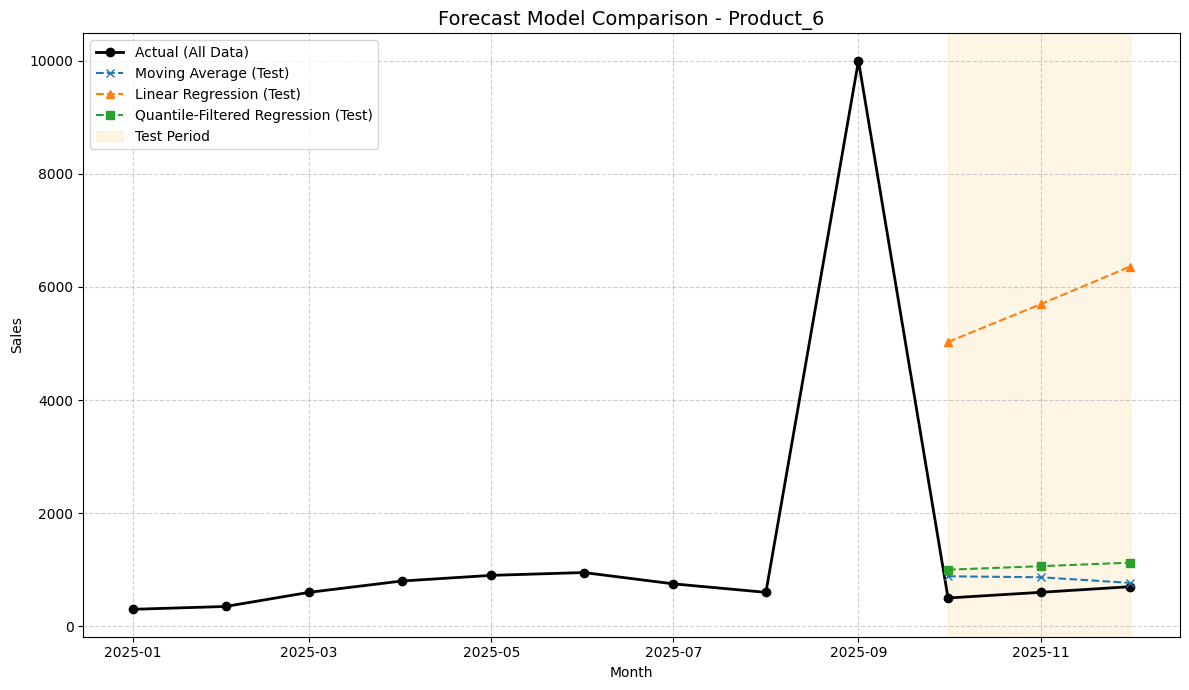

In [27]:
# Evaluate
actual = test_df["Sales"].values
mape_ma = mean_absolute_percentage_error(actual, ma_pred)
mape_lr = mean_absolute_percentage_error(actual, lr_pred)
mape_qf = mean_absolute_percentage_error(actual, qf_pred)

print(f"📈 Product: {product_name}")
print(f"MAPE - Moving Average: {mape_ma:.2%}")
print(f"MAPE - Linear Regression: {mape_lr:.2%}")
print(f"MAPE - Quantile-Filtered Regression: {mape_qf:.2%}")

# Pick best
mape_scores = {
    "Moving Average": mape_ma,
    "Linear Regression": mape_lr,
    "Quantile-Filtered Regression": mape_qf
}
best_model = min(mape_scores, key=mape_scores.get)
print(f"✅ Best model selected: {best_model}")

# 📊 Plot actual vs predictions, including all data and test period highlight
plt.figure(figsize=(12, 7))

# Plot all actual sales (train + test)
plt.plot(product_df["Month"], product_df["Sales"], label="Actual (All Data)", color="black", marker="o", linewidth=2)

# Plot predictions (only for test period)
plt.plot(test_df["Month"], ma_pred, label="Moving Average (Test)", linestyle="--", marker="x")
plt.plot(test_df["Month"], lr_pred, label="Linear Regression (Test)", linestyle="--", marker="^")
plt.plot(test_df["Month"], qf_pred, label="Quantile-Filtered Regression (Test)", linestyle="--", marker="s")

# Highlight test period
plt.axvspan(test_df["Month"].iloc[0], test_df["Month"].iloc[-1], color="orange", alpha=0.1, label="Test Period")

plt.title(f"Forecast Model Comparison - {product_name}", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Forecast Jan–Mar 2026
future_months = pd.date_range(start="2026-01-01", periods=3, freq="MS")
future_index = np.arange(len(product_df), len(product_df) + 3)

if best_model == "Linear Regression":
    future_forecast = linear_regression_forecast(train_index, train_df["Sales"].values, future_index)
elif best_model == "Quantile-Filtered Regression":
    future_forecast = quantile_filtered_forecast(train_index, train_df["Sales"].values, future_index)
else:
    ma_series = moving_average_forecast(product_df["Sales"])
    future_forecast = [ma_series.dropna().iloc[-1]] * 3

forecast_result = pd.DataFrame({
    "Month": future_months.strftime("%b-%Y"),
    "Forecasted Sales": np.round(future_forecast, 2),
    "Model Used": best_model
})

forecast_result
